# Machine Learning in Keras

### Brief Review of Machine Learning

In supervised learning, parametric models are those where the model is a function of a fixed form with a number of unknown _parameters_.  Together with a loss function and a training set, an optimizer can select parameters to minimize the loss with respect to the training set.  Common optimizers include stochastic gradient descent.  It tweaks the parameters slightly to move the loss "downhill" due to a small batch of examples from the training set.

### Linear & Logistic Regression

You've likely seen linear regression before.  In linear regression, we fit a line (technically, hyperplane) that predicts a target variable, $y$, based on some features $x$.  The form of this model is affine (even if we call it "linear"):  

$$y_{hat} = xW + b$$

where $W$ and $b$ are weights and an offset, respectively, and are the parameters of this parametric model.  The loss function that the optimizer uses to fit these parameters is the squared error ($||\cdots||_2$) between the prediction and the ground truth in the training set.

You've also likely seen logistic regression, which is tightly related to linear regression.  Logistic regression also fits a line - this time separating the positive and negative examples of a binary classifier.  The form of this model is similar:

$$y_{hat} = \sigma(xW + b)$$

where again $W$ and $b$ are the parameters of this model, and $\sigma$ is the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) which maps un-normalized scores ("logits") to values $\hat{y} \in [0,1]$ that represent probabilities. The loss function that the optimizer uses to fit these parameters is the cross entropy between the prediction and the ground truth in the training set.

This pattern of an affine transform, $xW + b$, occurs over and over in machine learning.

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
def generate_data(num_train, num_test):
    np.random.seed(1)
    num = num_train + num_test
    x0 = np.random.randn(num, 2) + 3.*np.array([1, 0])
    x1 = np.random.randn(num, 2) + 1.*np.array([-1, 0])
    X = np.vstack([x0, x1])
    y = np.concatenate([
        np.zeros(num), np.ones(num)])

    # Randomly shuffle the data
    shuf_idx = np.random.permutation(len(y))
    X = X[shuf_idx]
    y = y[shuf_idx]

    return X[:num_train], y[:num_train], X[num_train:num], y[num_train:num]


def generate_non_linear_data(num_train, num_test):
    np.random.seed(1)
    num = num_train + num_test
    x0 = np.random.randn(num, 2) + 4.*np.array([1, 0])
    x1 = np.random.randn(num, 2) + 4.*np.array([0, 1])
    x2 = np.random.randn(num, 2) + 4.*np.array([-1, 0])
    x3 = np.random.randn(num, 2) + 4.*np.array([0, -2])
    X = np.vstack([x0, x1, x2, x3])
    y = np.concatenate([
        np.zeros(num), np.ones(num),
        np.zeros(num), np.ones(num)])

    # Randomly shuffle the data
    shuf_idx = np.random.permutation(len(y))
    X = X[shuf_idx]
    y = y[shuf_idx]

    return X[:num_train], y[:num_train], X[num_train:num], y[num_train:num]

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

(2500, 2)
(500, 2)


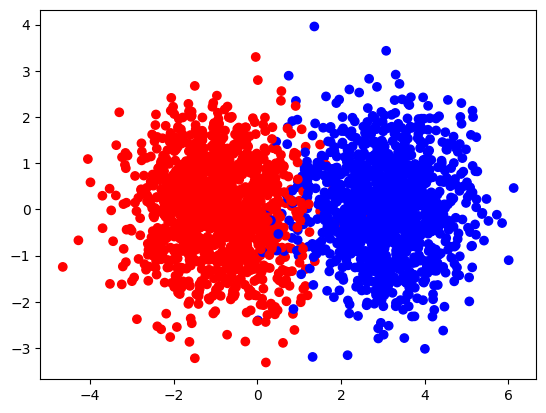

In [ ]:
X_train, y_train, X_test, y_test = generate_data(2500, 500) #large test size to make diagrams better
print(X_train.shape)
print(X_test.shape)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr');

### Training Logistic Regression

It's clear that the data is separable with a vertical line.  The simplest model we can use for this data is logistic regression.  Let's do that.

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.15.0


In [ ]:
linear_model = keras.Sequential([
    # Dense is an affine (xW + b) layer followed by an element wise nonlinearity.
    keras.layers.Dense(1, activation='sigmoid')
])

linear_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

linear_model.fit(X_train, y_train, epochs=15)

Epoch 1/15
79/79 [==============================] - 1s 2ms/step - loss: 0.8711 - accuracy: 0.3864
Epoch 2/15
79/79 [==============================] - 0s 2ms/step - loss: 0.7798 - accuracy: 0.4508
Epoch 3/15
79/79 [==============================] - 0s 2ms/step - loss: 0.7009 - accuracy: 0.5396
Epoch 4/15
79/79 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.6420
Epoch 5/15
79/79 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.7392
Epoch 6/15
79/79 [==============================] - 0s 2ms/step - loss: 0.5214 - accuracy: 0.8168
Epoch 7/15
79/79 [==============================] - 0s 2ms/step - loss: 0.4772 - accuracy: 0.8712
Epoch 8/15
79/79 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.9124
Epoch 9/15
79/79 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.9320
Epoch 10/15
79/79 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.9456
Epoch 11/15
79/79 [

**Hint:** You should expect to see an initial loss here of 0.2 - 1.2.  This is because a well-initialized random classifier tends to output a uniform distribution.  For each example in the batch, we either compute the cross-entropy loss of the label (`[1, 0]` or `[0, 1]`) against the model's output (`~[0.5, 0.5]`).  Both cases result in $-\lg(0.5) = lg(2) = 1.0$.

Of course, your random classifier won't output exactly uniform distributions (it's random after all), but you should anticipate it being pretty close.  If it's not, your initialization may be broken and make it hard for your network to learn.

**[Optional]** Some technical details... if your randomly initialized network is outputting very confident predictions, the loss computed may be very large while at the same time the sigmoids in the network are likely in saturation, quickly shrinking gradients.  The result is that you make tiny updates in the face of a huge loss.

Let's use our model to make predictions on the test set:

In [ ]:
last_epoch_accuracy = pd.DataFrame(linear_model.history.history).tail(1)["accuracy"].to_list()[0]
last_epoch_accuracy

0.9692000150680542

16/16 [==============================] - 0s 1ms/step


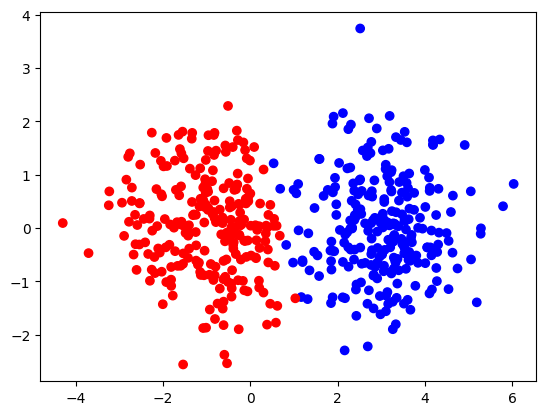

In [ ]:
predictions = linear_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

### But what about a harder problem?

The case above, the data was linearly separable making it susceptible to a linear classifier.

But what if you had data that looked more like this?

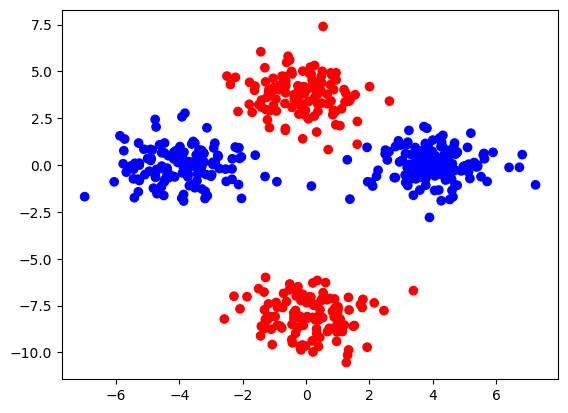

In [ ]:
X_train, y_train, X_test, y_test = generate_non_linear_data(2500, 500)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='bwr')

In [ ]:
linear_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
79/79 [==============================] - 0s 2ms/step - loss: 1.0460 - accuracy: 0.6144
Epoch 2/10
79/79 [==============================] - 0s 2ms/step - loss: 0.9498 - accuracy: 0.6200
Epoch 3/10
79/79 [==============================] - 0s 2ms/step - loss: 0.8726 - accuracy: 0.6124
Epoch 4/10
79/79 [==============================] - 0s 2ms/step - loss: 0.8104 - accuracy: 0.5904
Epoch 5/10
79/79 [==============================] - 0s 2ms/step - loss: 0.7637 - accuracy: 0.5712
Epoch 6/10
79/79 [==============================] - 0s 2ms/step - loss: 0.7296 - accuracy: 0.5492
Epoch 7/10
79/79 [==============================] - 0s 2ms/step - loss: 0.7066 - accuracy: 0.5252
Epoch 8/10
79/79 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5124
Epoch 9/10
79/79 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.5064
Epoch 10/10
79/79 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.5028


Again, let's make predictions on the test set...

In [ ]:
pd.DataFrame(linear_model.history.history)

,loss,accuracy
0,1.045952,0.6144
1,0.949757,0.6200
2,0.872580,0.6124
3,0.810380,0.5904
4,0.763704,0.5712
5,0.729577,0.5492
6,0.706582,0.5252
7,0.691323,0.5124
8,0.681845,0.5064
9,0.675560,0.5028


16/16 [==============================] - 0s 2ms/step


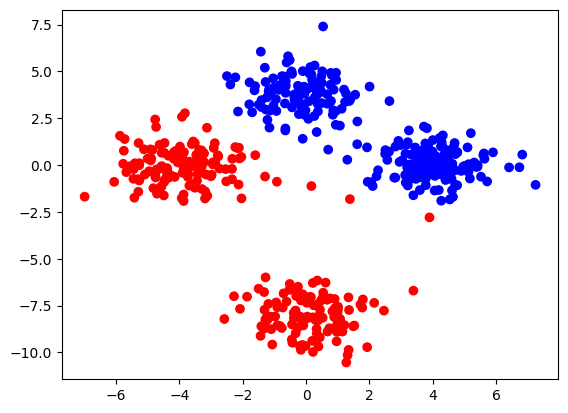

In [ ]:
predictions = linear_model.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=predictions[:,0]>0.5, cmap='bwr')

That isn't very good!

### Building a deeper network with the Sequential API

In [ ]:
FIXED_EPOCHS = 10
fit_verbose = False
optuna_trials = 25

### Experiment 1 : Keep the layer size, epochs fixed, and just change the number of hidden layers and learning rate.

def objective(trial):

    # Suggestions
    n_layers = trial.suggest_int('n_layers', 1, 6)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    n_neurons = trial.suggest_int('n_neurons', 5, 15)

    # Build the Keras model
    model = Sequential()
    for _ in range(n_layers):
        model.add(Dense(n_neurons, activation='relu'))

    # Fixed output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile and train the model
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=FIXED_EPOCHS, verbose=fit_verbose)

    # Return the validation accuracy of the last epoch
    accuracy = pd.DataFrame(model.history.history).tail(1)["accuracy"].to_list()[0]
    return accuracy

# Create a study object and optimize the objective
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=optuna_trials)

[I 2024-01-26 07:41:42,985] A new study created in memory with name: no-name-76c8618d-ae22-4bfa-9796-4ed4ce6a8d49
[I 2024-01-26 07:41:48,029] Trial 0 finished with value: 0.5055999755859375 and parameters: {'n_layers': 5, 'learning_rate': 1.731589508635591e-05, 'n_neurons': 6}. Best is trial 0 with value: 0.5055999755859375.
[I 2024-01-26 07:41:50,859] Trial 1 finished with value: 0.9968000054359436 and parameters: {'n_layers': 5, 'learning_rate': 0.00019981359588283263, 'n_neurons': 12}. Best is trial 1 with value: 0.9968000054359436.
[I 2024-01-26 07:41:54,281] Trial 2 finished with value: 0.5044000148773193 and parameters: {'n_layers': 2, 'learning_rate': 2.9360056307821697e-05, 'n_neurons': 15}. Best is trial 1 with value: 0.9968000054359436.
[I 2024-01-26 07:41:58,951] Trial 3 finished with value: 0.9908000230789185 and parameters: {'n_layers': 2, 'learning_rate': 0.00018436608142956024, 'n_neurons': 11}. Best is trial 1 with value: 0.9968000054359436.
[I 2024-01-26 07:42:02,868] 

In [ ]:
best_params = study.best_params
print('Best params found:', best_params)

Best params found: {'n_layers': 4, 'learning_rate': 0.0003845256329418518, 'n_neurons': 15}


In [ ]:
fig = plot_contour(study, params=["n_layers", "learning_rate"])
fig.show()

In [ ]:
fig = plot_contour(study, params=["n_layers", "n_neurons"])
fig.show()

In [ ]:
fig = plot_optimization_history(study)
fig.show()

In [ ]:
fig = plot_param_importances(study)
fig.show()

In [ ]:
fig = plot_timeline(study)
fig.show()

<ipython-input-66-0948cc85c515>:1: ExperimentalWarning:

plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.



In [ ]:
fig = plot_rank(study)
fig.show()

<ipython-input-67-2ee677bb362d>:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [ ]:
fig = plot_slice(study)
fig.show()